In [1]:
import numpy as np 
import scipy.optimize as sciop
from scipy.interpolate import interp1d
# -- astropy -- 
import astropy.units as u
from astropy.table import Table as aTable
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
boss_blue = aTable.read(''.join([UT.dat_dir(), 'sky/', 'Bright_BOSS_Sky_blue.fits']))

In [4]:
boss_wlim410 = ((boss_blue[0]['WAVE'] > 405.) & (boss_blue[0]['WAVE'] < 415.))
boss_sky410 = np.array([np.average(boss_blue[i]['SKY'][boss_wlim410])/np.pi for i in range(len(boss_blue))])

In [5]:
specsim_sky = Sky.specsim_initialize('desi')
specsim_wave = specsim_sky._wavelength # Ang

/anaconda2/lib/python2.7/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [6]:
cr_def = specsim_sky.moon.KS_CR
cm0_def = specsim_sky.moon.KS_CM0
cm1_def = specsim_sky.moon.KS_CM1
print('Default C_R = %f, C_M0 = %f, C_M1 = %f' % (cr_def, cm0_def, cm1_def))

Default C_R = 229086.765277, C_M0 = 6.150000, C_M1 = 40.000000


In [7]:
print('Re-scaled C_R = %f, C_M0 = %f, C_M1 = %f' % (10**5.661030, 5.540103, 178.141045))

Re-scaled C_R = 458173.535128, C_M0 = 5.540103, C_M1 = 178.141045


In [8]:
def KS_sky(airmass, moonill, moonalt, moonsep): 
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    specsim_sky.moon.KS_CR = cr_def
    specsim_sky.moon.KS_CM0 = cm0_def
    specsim_sky.moon.KS_CM1 = cm1_def
    return specsim_sky.surface_brightness

In [9]:
def KSrescaled_sky(airmass, moonill, moonalt, moonsep): 
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    specsim_sky.moon.KS_CR = 458173.535128
    specsim_sky.moon.KS_CM0 = 5.540103
    specsim_sky.moon.KS_CM1 = 178.141045
    return specsim_sky.surface_brightness

In [10]:
ks_wlim410 = ((specsim_wave.value > 4050.) & (specsim_wave.value < 4150.))
ks_sky410 = np.zeros(len(boss_blue))
ks_rescaled_sky410 = np.zeros(len(boss_blue))
for i in range(len(boss_blue)): 
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])
    ks_sky410[i] = np.average(ks_i.value[ks_wlim410])
    ks_i = KSrescaled_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])
    ks_rescaled_sky410[i] = np.average(ks_i.value[ks_wlim410])

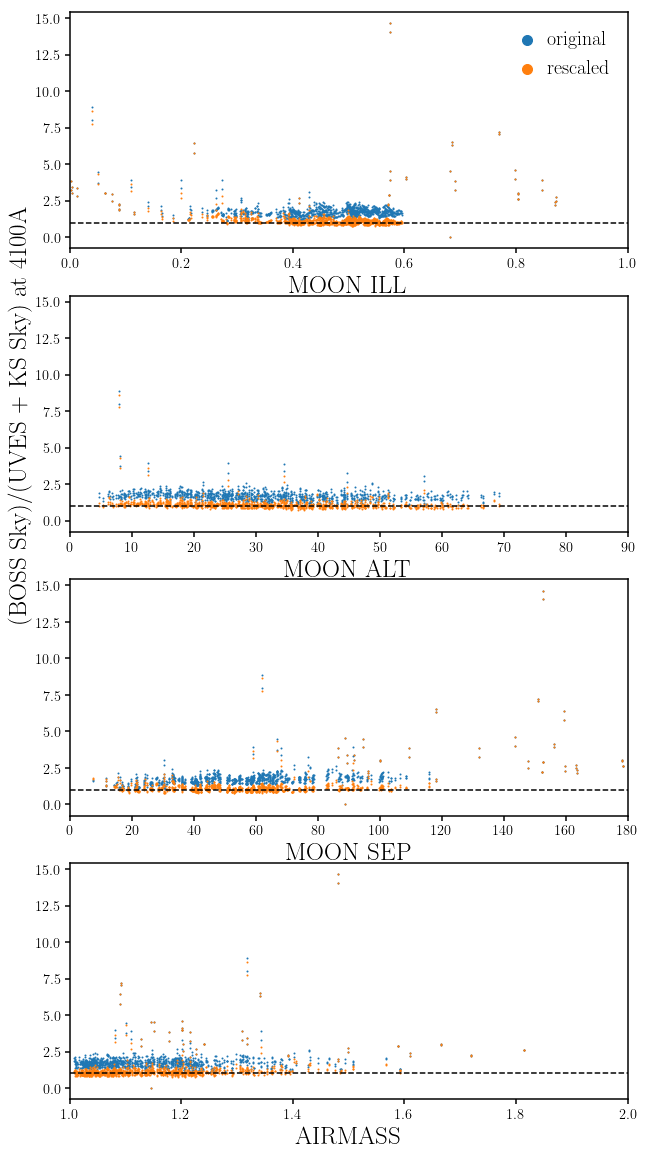

In [11]:
fig = plt.figure(figsize=(10, 20))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS']): 
    sub = fig.add_subplot(4,1,i+1)
    sub.scatter(boss_blue[k], boss_sky410/ks_sky410, c='C0', s=1, label='original')
    sub.scatter(boss_blue[k], boss_sky410/ks_rescaled_sky410, c='C1', s=1, label='rescaled')
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('(BOSS Sky)/(UVES + KS Sky) at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])
    sub.plot(sub.get_xlim(), [1., 1.], color='k', linestyle='--')

In [12]:
import pandas as pd
f = ''.join([UT.code_dir(), 'dat/sky/MoonResults.csv'])

coeffs = pd.DataFrame.from_csv(f)
coeffs.columns = [
    'wl', 'model', 'data_var', 'unexplained_var',' X2', 'rX2',
    'c0', 'c_am', 'tau', 'tau2', 'c_zodi', 'c_isl', 'sol', 'I',
    't0', 't1', 't2', 't3', 't4', 'm0', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6',
    'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec',
    'c2', 'c3', 'c4', 'c5', 'c6']
# keep moon models
twi_coeffs = coeffs[coeffs['model'] == 'twilight']
coeffs = coeffs[coeffs['model'] == 'moon']
# order based on wavelengths for convenience
wave_sort = np.argsort(np.array(coeffs['wl']))

for k in coeffs.keys():
    coeffs[k] = np.array(coeffs[k])[wave_sort]

for k in twi_coeffs.keys():
    twi_coeffs[k] = np.array(twi_coeffs[k])[wave_sort]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  after removing the cwd from sys.path.


In [13]:
def cI_twi(alpha, delta, airmass): 
    twi = (
        twi_coeffs['t0'] * np.abs(alpha) + # CT2
        twi_coeffs['t1'] * np.abs(alpha)**2 +      # CT1
        twi_coeffs['t2'] * np.abs(delta)**2 +      # CT3
        twi_coeffs['t3'] * np.abs(delta)           # CT4
    ) * np.exp(-twi_coeffs['t4'] * airmass) + twi_coeffs['c0']
    return np.array(twi)

In [14]:
def KSrescaled_twi_sky(airmass, moonill, moonalt, moonsep, sun_alt, sun_sep): 
    specsim_sky.airmass = airmass
    specsim_sky.moon.moon_phase = np.arccos(2.*moonill - 1)/np.pi
    specsim_sky.moon.moon_zenith = (90. - moonalt) * u.deg
    specsim_sky.moon.separation_angle = moonsep * u.deg
    specsim_sky.moon.KS_CR = 458173.535128
    specsim_sky.moon.KS_CM0 = 5.540103
    specsim_sky.moon.KS_CM1 = 178.141045
    I_ks_rescale = specsim_sky.surface_brightness
    if sun_alt > -20.: 
        I_twi = cI_twi(sun_alt, sun_sep, airmass)/np.pi
        I_twi_interp = interp1d(10.*np.array(coeffs['wl']), I_twi, fill_value='extrapolate')
        return I_ks_rescale.value + I_twi_interp(specsim_wave.value)
    else: 
        return I_ks_rescale.value

In [15]:
ks_rescaled_twi_sky410 = np.zeros(len(boss_blue))
for i in range(len(boss_blue)): 
    ks_i = KSrescaled_twi_sky(
        boss_blue['AIRMASS'][i], 
        boss_blue['MOON_ILL'][i], 
        boss_blue['MOON_ALT'][i], 
        boss_blue['MOON_SEP'][i], 
        boss_blue['SUN_ALT'][i], 
        boss_blue['SUN_SEP'][i])
    ks_rescaled_twi_sky410[i] = np.average(ks_i[ks_wlim410])

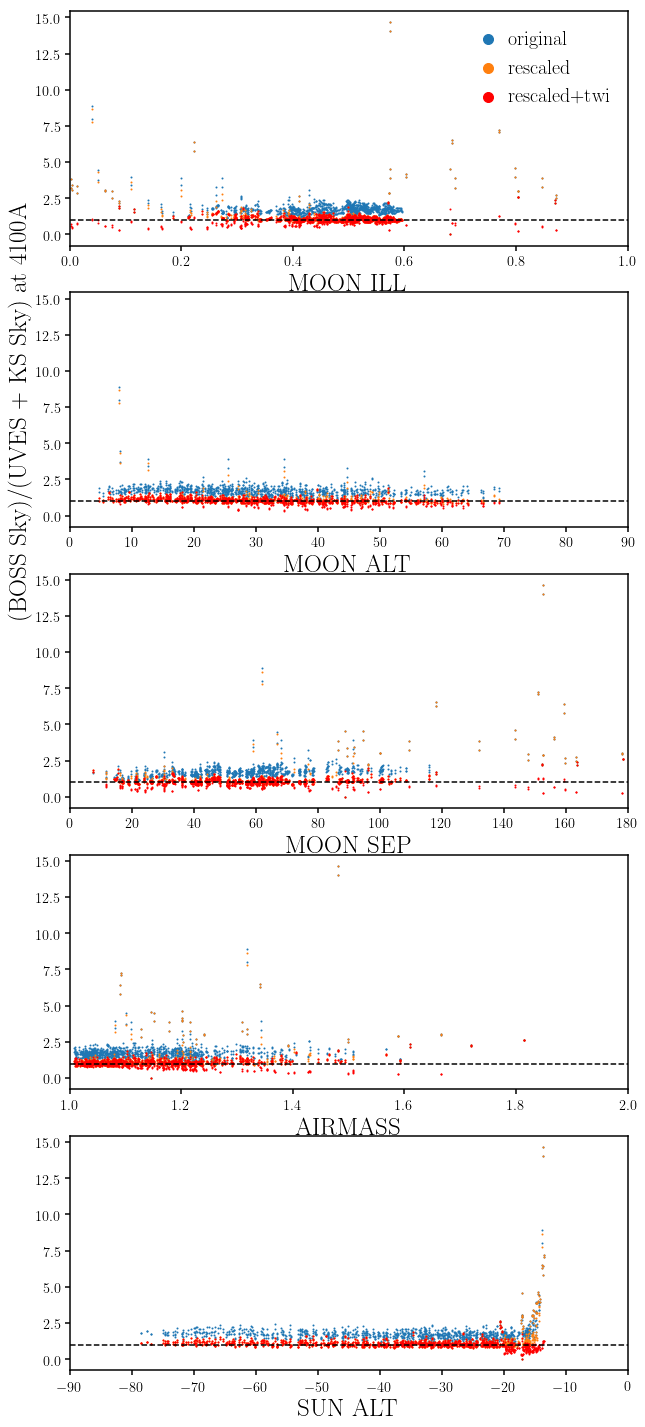

In [38]:
fig = plt.figure(figsize=(10, 25))
for i, k in enumerate(['MOON_ILL', 'MOON_ALT', 'MOON_SEP', 'AIRMASS', 'SUN_ALT']): 
    sub = fig.add_subplot(5,1,i+1)
    sub.scatter(boss_blue[k], boss_sky410/ks_sky410, c='C0', s=1, label='original')
    sub.scatter(boss_blue[k], boss_sky410/ks_rescaled_sky410, c='C1', s=1, label='rescaled')
    sub.scatter(boss_blue[k], boss_sky410/ks_rescaled_twi_sky410, c='r', s=1, label='rescaled+twi')
    sub.set_xlabel(' '.join(k.split('_')), fontsize=25)
    if i == 0: 
        sub.legend(loc='upper right', handletextpad=0, markerscale=10, fontsize=20)
        sub.set_xlim([0.,1.])
    elif i == 1: 
        sub.set_xlim([0., 90.])
        sub.set_ylabel('(BOSS Sky)/(UVES + KS Sky) at 4100A', fontsize=25)
    elif i == 2: 
        sub.set_xlim([0., 180.])
    elif i == 3: 
        sub.set_xlim([1., 2.])
    elif i == 4:
        sub.set_xlim([-90., 0.])
    sub.plot(sub.get_xlim(), [1., 1.], color='k', linestyle='--')

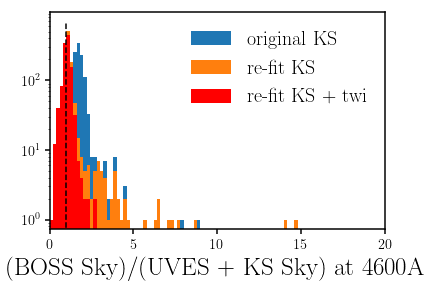

In [18]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist(boss_sky410/ks_sky410, range=(0., 20.), bins=100, color='C0', label='original KS')
sub.hist(boss_sky410/ks_rescaled_sky410, range=(0., 20.), bins=100, color='C1', label='re-fit KS')
sub.hist(boss_sky410/ks_rescaled_twi_sky410, range=(0., 20.), bins=100, color='r', label='re-fit KS + twi')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('(BOSS Sky)/(UVES + KS Sky) at 4600A', fontsize=25)
sub.set_xlim([0., 20.])
sub.set_yscale("log")
_, ymax = sub.get_ylim()
sub.vlines(1., 0, ymax, color='k', linestyle='--')

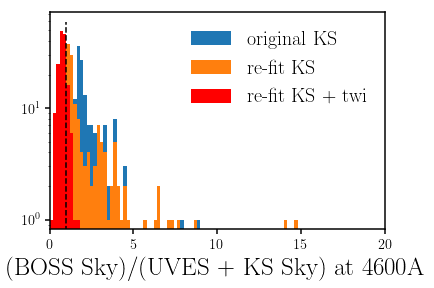

In [39]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.hist((boss_sky410/ks_sky410)[high_sun], range=(0., 20.), bins=100, color='C0', label='original KS')
sub.hist((boss_sky410/ks_rescaled_sky410)[high_sun], range=(0., 20.), bins=100, color='C1', label='re-fit KS')
sub.hist((boss_sky410/ks_rescaled_twi_sky410)[high_sun], range=(0., 20.), bins=100, color='r', label='re-fit KS + twi')
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('(BOSS Sky)/(UVES + KS Sky) at 4600A', fontsize=25)
sub.set_xlim([0., 20.])
sub.set_yscale("log")
_, ymax = sub.get_ylim()
sub.vlines(1., 0, ymax, color='k', linestyle='--')

Now lets check how well the new rescaled KS + twilight model does over the full wavelength range

Text(0.5,0,'wavelength')

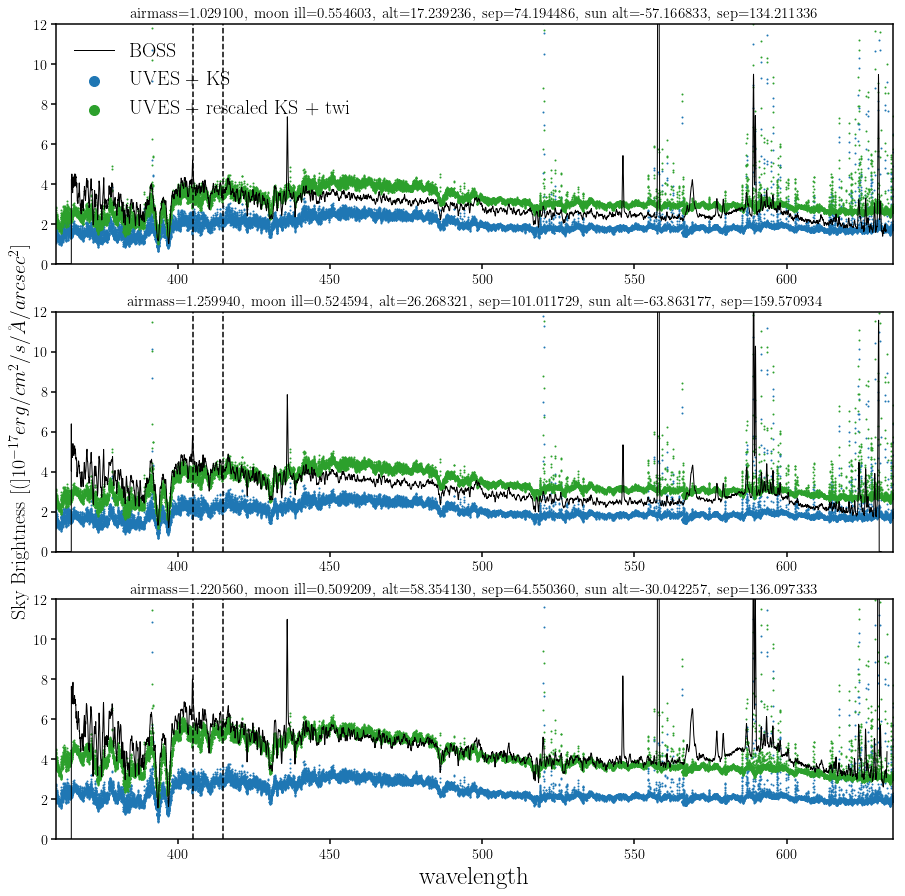

In [26]:
fig = plt.figure(figsize=(15,15))
for ii, i in enumerate(np.random.choice(range(len(boss_blue)), 3, replace=False)): #[0, 1, 2]):#
    # get the UVES + KS sky given observing parameters
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])
    #ks_rescale_i = KSrescaled_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])
    ks_rescale_twi_i = KSrescaled_twi_sky(
        boss_blue['AIRMASS'][i], 
        boss_blue['MOON_ILL'][i], 
        boss_blue['MOON_ALT'][i], 
        boss_blue['MOON_SEP'][i], 
        boss_blue['SUN_ALT'][i], 
        boss_blue['SUN_SEP'][i])
    
    sub = fig.add_subplot(3,1,ii+1)
    sub.plot(boss_blue['WAVE'][i], boss_blue['SKY'][i]/np.pi, lw=1, c='k', label='BOSS')
    sub.scatter(specsim_wave/10., ks_i, s=1, c='C0', label='UVES + KS')
    #sub.scatter(specsim_wave/10., ks_rescale_i, s=1, c='C1', label='UVES + rescaled KS')
    sub.scatter(specsim_wave/10., ks_rescale_twi_i, s=1, c='C2', label='UVES + rescaled KS + twi')
    sub.vlines(405., 0., 12, color='k', linestyle='--')
    sub.vlines(415., 0., 12, color='k', linestyle='--')
    sub.set_xlim([360., 635])
    if ii == 0: sub.legend(loc='upper left', markerscale=10, fontsize=20)
    if ii == 1: 
        sub.set_ylabel('Sky Brightness [(]$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
    sub.set_ylim([0., 12])
    sub.set_title(('airmass=%f, moon ill=%f, alt=%f, sep=%f, sun alt=%f, sep=%f' % (boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], boss_blue['SUN_ALT'][i], boss_blue['SUN_SEP'][i])), fontsize=15)
sub.set_xlabel('wavelength', fontsize=25)

Text(0.5,0,'wavelength')

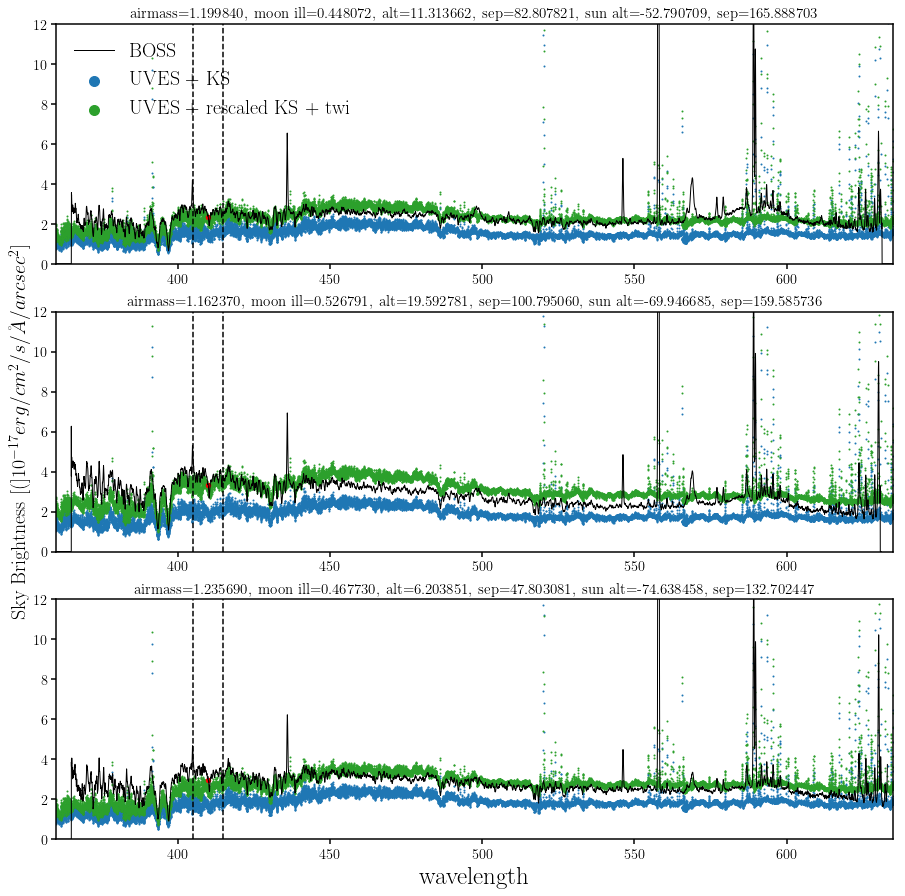

In [35]:
fig = plt.figure(figsize=(15,15))
for ii, i in enumerate(np.random.choice(range(len(boss_blue)), 3, replace=False)): #[0, 1, 2]):#
    # get the UVES + KS sky given observing parameters
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])
    #ks_rescale_i = KSrescaled_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])
    ks_rescale_twi_i = KSrescaled_twi_sky(
        boss_blue['AIRMASS'][i], 
        boss_blue['MOON_ILL'][i], 
        boss_blue['MOON_ALT'][i], 
        boss_blue['MOON_SEP'][i], 
        boss_blue['SUN_ALT'][i], 
        boss_blue['SUN_SEP'][i])
    
    sub = fig.add_subplot(3,1,ii+1)
    sub.plot(boss_blue['WAVE'][i], boss_blue['SKY'][i]/np.pi, lw=1, c='k', label='BOSS')
    sub.scatter(specsim_wave/10., ks_i, s=1, c='C0', label='UVES + KS')
    #sub.scatter(specsim_wave/10., ks_rescale_i, s=1, c='C1', label='UVES + rescaled KS')
    sub.scatter(specsim_wave/10., ks_rescale_twi_i, s=1, c='C2', label='UVES + rescaled KS + twi')
    sub.vlines(405., 0., 12, color='k', linestyle='--')
    sub.vlines(415., 0., 12, color='k', linestyle='--')
    sub.set_xlim([360., 635])
    if ii == 0: sub.legend(loc='upper left', markerscale=10, fontsize=20)
    if ii == 1: 
        sub.set_ylabel('Sky Brightness [(]$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
    sub.set_ylim([0., 12])
    sub.set_title(('airmass=%f, moon ill=%f, alt=%f, sep=%f, sun alt=%f, sep=%f' % (boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], boss_blue['SUN_ALT'][i], boss_blue['SUN_SEP'][i])), fontsize=15)
sub.set_xlabel('wavelength', fontsize=25)

Text(0.5,0,'wavelength')

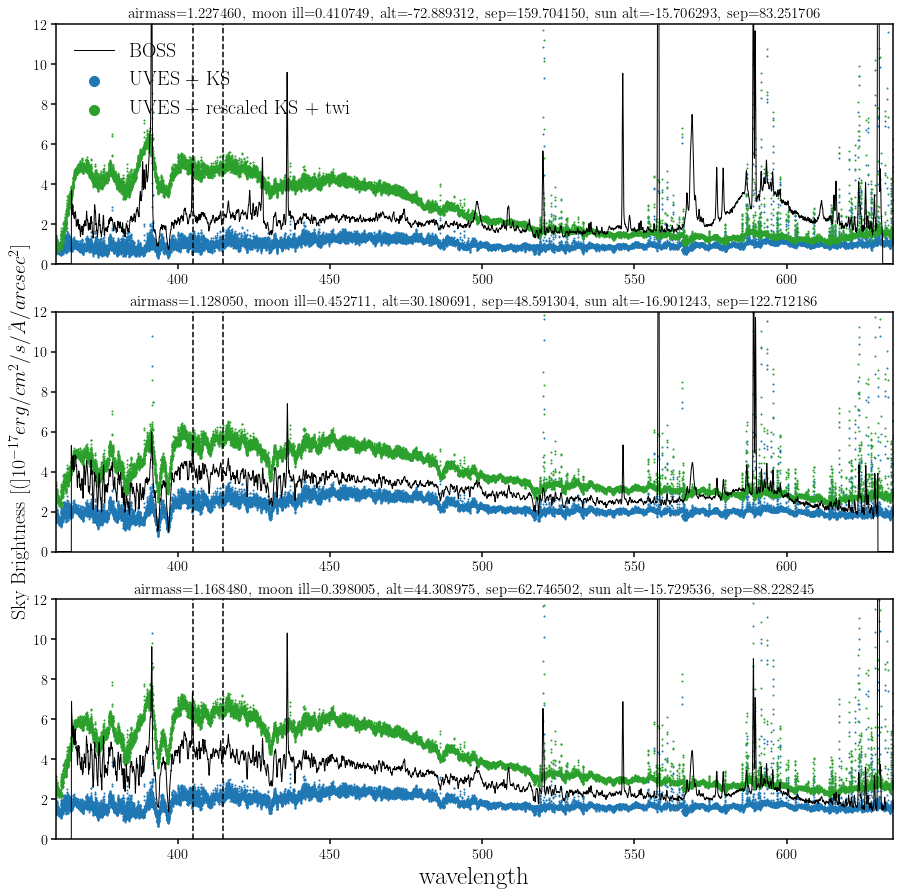

In [34]:
high_sun = (boss_blue['SUN_ALT'] > -18.)


fig = plt.figure(figsize=(15,15))
#for ii, i in enumerate(np.random.choice(range(len(boss_blue)), 3, replace=False)): #[0, 1, 2]):#
for ii, i in enumerate(np.random.choice(np.arange(len(boss_blue))[high_sun], 3, replace=False)):
    # get the UVES + KS sky given observing parameters
    ks_i = KS_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])
    #ks_rescale_i = KSrescaled_sky(boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i])
    ks_rescale_twi_i = KSrescaled_twi_sky(
        boss_blue['AIRMASS'][i], 
        boss_blue['MOON_ILL'][i], 
        boss_blue['MOON_ALT'][i], 
        boss_blue['MOON_SEP'][i], 
        boss_blue['SUN_ALT'][i], 
        boss_blue['SUN_SEP'][i])
    
    sub = fig.add_subplot(3,1,ii+1)
    sub.plot(boss_blue['WAVE'][i], boss_blue['SKY'][i]/np.pi, lw=1, c='k', label='BOSS')
    sub.scatter(specsim_wave/10., ks_i, s=1, c='C0', label='UVES + KS')
    #sub.scatter(specsim_wave/10., ks_rescale_i, s=1, c='C1', label='UVES + rescaled KS')
    sub.scatter(specsim_wave/10., ks_rescale_twi_i, s=1, c='C2', label='UVES + rescaled KS + twi')
    sub.vlines(405., 0., 12, color='k', linestyle='--')
    sub.vlines(415., 0., 12, color='k', linestyle='--')
    sub.set_xlim([360., 635])
    if ii == 0: sub.legend(loc='upper left', markerscale=10, fontsize=20)
    if ii == 1: 
        sub.set_ylabel('Sky Brightness [(]$10^{-17} erg/cm^{2}/s/\AA/arcsec^2$]', fontsize=20)
    sub.set_ylim([0., 12])
    sub.set_title(('airmass=%f, moon ill=%f, alt=%f, sep=%f, sun alt=%f, sep=%f' % (boss_blue['AIRMASS'][i], boss_blue['MOON_ILL'][i], boss_blue['MOON_ALT'][i], boss_blue['MOON_SEP'][i], boss_blue['SUN_ALT'][i], boss_blue['SUN_SEP'][i])), fontsize=15)
sub.set_xlabel('wavelength', fontsize=25)